### Automated anomaly detection using PyOD and Auto-Sklearn
This notebook incorporates anomaly detection algorithms from PyOD into Auto-Sklearn. The following steps are followed:
- Auto-Sklearn is extended to incorporate PyOD algorithms
- Anomaly detection dataset(s) are imported and pre-processed
- Dataset is passed to Auto-Sklearn automl object for automated modeling and prediction
- Results and stats are obtained and analyzed

In [8]:
# Imports
import os, sys
import pandas as pd
import numpy as np
import sklearn.metrics
import autosklearn.classification
from sklearn.model_selection import train_test_split
from autosklearn.pipeline.components.classification import add_classifier
from autosklearn.metrics import roc_auc, average_precision
from scipy.io import arff
from matplotlib import pyplot as plt
p = os.path.abspath('..')
sys.path.insert(1, p)
from utils import custom_split, balanced_split, add_pyod_models_to_pipeline, \
    get_metric_result
# Add models to Auto-Sklearn
add_pyod_models_to_pipeline()

In [9]:
# Shuttle dataset
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
mat = loadmat('../../data/shuttle.mat')  # load mat-file
X = mat['X']
y = mat['y']
X = pd.DataFrame(X)
y = pd.DataFrame(y)
y = y[0]
N = 5000
if(len(X) > N):
    X = X.sample(n=N, ignore_index=True, random_state=1)
    y = y.sample(n=N, ignore_index=True, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y) # stratified split
# Reset indexes
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
print("Ratio of outliers in training set:", len(y_train[y_train==1])/len(y_train))
print("Ratio of outliers in test set:", len(y_test[y_test==1])/len(y_test))
print("Training size:", len(X_train))
print("Test size:", len(X_test))

Ratio of outliers in training set: 0.0675
Ratio of outliers in test set: 0.068
Training size: 4000
Test size: 1000


In [10]:
# Pre-defined split indices for train and validation
#selected_indices = custom_split(y_train)
selected_indices = balanced_split(y_train)
# Define custom resampling strategy
resampling_strategy = sklearn.model_selection.PredefinedSplit(test_fold=selected_indices)
# Build and fit a classifier
automl = autosklearn.classification.AutoSklearnClassifier(
    include = {
      'classifier': [
          'ABODClassifier',
          'CBLOFClassifier',
          'COPODClassifier',
          'ECODClassifier',
          'HBOSClassifier',
          'IForestClassifier',
          'KNNClassifier',
          'LMDDClassifier',
          'LOFClassifier',
          'MCDClassifier',
          'OCSVMClassifier',
          'PCAClassifier',
          'RODClassifier',
          'SOSClassifier'
      ],
      'feature_preprocessor': ["no_preprocessing"],
    },
    exclude = None,
    metric = roc_auc,
    scoring_functions = [roc_auc, average_precision],
    time_left_for_this_task = 120,
    per_run_time_limit = 20,
    ensemble_size = 1,
    initial_configurations_via_metalearning = 0,
    resampling_strategy = resampling_strategy,
)
# Fit
print('Running fit...')
automl.fit(X_train, y_train, X_test, y_test, dataset_name='Shuttle')

Number of total samples to split: 4000
Number of outliers in training: 1
Number of outliers in test: 269
Number of normal points in training: 3461
Number of normal points in test: 269
Running fit...


AutoSklearnClassifier(ensemble_size=1,
                      include={'classifier': ['ABODClassifier',
                                              'CBLOFClassifier',
                                              'COPODClassifier',
                                              'ECODClassifier',
                                              'HBOSClassifier',
                                              'IForestClassifier',
                                              'KNNClassifier', 'LMDDClassifier',
                                              'LOFClassifier', 'MCDClassifier',
                                              'OCSVMClassifier',
                                              'PCAClassifier', 'RODClassifier',
                                              'SOSClassifier'],
                               'feature_preprocessor': ['no_preprocessing']},
                      initial_configurations_via_metalearning=0, metric=roc_auc,
                      per_run_time_limit=20

In [11]:
# auto-sklearn execution details
print(automl.sprint_statistics())
# Top ranked model
#print(automl.leaderboard(top_k=10))
# Top ranked model configuration
#print()
#print(automl.show_models())
# Call the function
print(get_metric_result(automl.cv_results_).to_string(index=False))

auto-sklearn results:
  Dataset name: Shuttle
  Metric: roc_auc
  Best validation score: 0.999986
  Number of target algorithm runs: 10
  Number of successful target algorithm runs: 6
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 3
  Number of target algorithms that exceeded the memory limit: 0

 rank_test_scores  status param_classifier:__choice__  mean_test_score  mean_fit_time  metric_roc_auc  metric_average_precision
                1 Success               LOFClassifier         0.999986       2.054908        0.999986                  0.999986
                2 Success               RODClassifier         0.998521      18.074966        0.998521                  0.998594
                3 Success              HBOSClassifier         0.997305       4.912902        0.997305                  0.996410
                4 Success              HBOSClassifier         0.996324       4.995302        0.996324                  0.994255
    

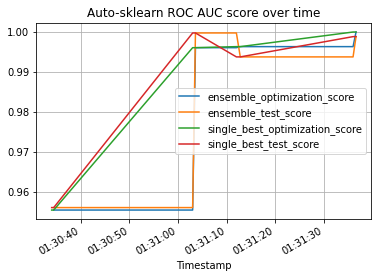

In [12]:
# Plot performance over time
automl.performance_over_time_.plot(
   x='Timestamp',
   kind='line',
   legend=True,
   title='Auto-sklearn ROC AUC score over time',
   grid=True,
)
plt.show()

In [13]:
print('Running refit...')
automl.refit(X_train, y_train)
# Evaluate on test set
y_pred=automl.predict_proba(X_test)
# score
score=sklearn.metrics.roc_auc_score(y_test,y_pred[:,1])
print("ROC AUC score:", score)

Running refit...
ROC AUC score: 0.5161417571320374
